# Part B: Regression Problem

In [63]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow_addons as tf_addons

import matplotlib.pyplot as plt

import math
from numpy import unique

histories = {}

In [64]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [65]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [66]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Q1
Real world datasets often contain a mix of numeric and categorical features – this dataset 
is one such example. Modelling such a mix of feature types with neural networks requires 
some modifications to the input layer. This tutorial from the Keras documentation guides 
you through the process of using the Functional API to do so.

a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets 
by using entries from year 2020 and before as training data (with the 
remaining data from year 2021 used as test data). 
Why is this done instead of random train/test splits?

In [67]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In this case, we are looking at data that are with date values. We use entries before 2020 as training data for data from 2021 as in this case, our data might be based on patterns in the data that are effects of the date and time, i.e. there might be some underlying relationships between the features and hence we would not want to remove that by using random splits.

Also, we are aiming to perform a prediction, which means we should take into account the timing of the prediction to make it accurate. We use 2020 and 2021 as these are the latest dates.

b) Following this tutorial, design a 2-layer feedforward neural network 
consisting of an input layer, a hidden layer (10 neurons, ReLU as activation 
function), and a linear output layer. One-hot encoding should be applied 
to categorical features and numeric features are standardised. After 
encoding / standardisation, the input features should be concatenated. 
The input layer should use these features: 
- Numeric features: dist_to_nearest_stn, dist_to_dhoby, 
degree_centrality, eigenvector_centrality, remaining_lease_years, 
floor_area_sqm
- Categorical features: month, flat_model_type, storey_range

In [68]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

all_inputs = [
    month,
    storey_range,
    flat_model_type,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm,
]


In [69]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)

c) On the training data, train the model for 100 epochs using mini-batch 
gradient descent with batch size = 128, Use ‘adam’ optimiser with a 
learning rate = 0.05 and mean square error as cost function.

In [70]:
#for f)
checkpoint_filepath = r'C:\Users\Admin\Desktop\NTU\CE4042\Assignment'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_root_mean_squared_error',
    mode = 'min', #use the best epoch 
    save_best_only = True)

In [71]:
batch_size = 128
learning_rate = 0.05
num_epochs = 100
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
mse = tf.keras.losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss = mse, metrics = [tf.keras.metrics.RootMeanSquaredError(), tf_addons.metrics.RSquare(y_shape=(1,))])
histories ['1c'] = model.fit(train_ds, batch_size = batch_size, 
                             epochs = num_epochs, validation_data = val_ds, 
                             callbacks = [model_checkpoint_callback])

Epoch 1/100


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 3s 3ms/step - loss: 187583053824.0000 - root_mean_squared_error: 433108.5938 - r_square: -6.8869 - val_loss: 171209719808.0000 - val_root_mean_squared_error: 413774.9688 - val_r_square: -5.5566
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 2/100
683/683 [==============================] - 2s 3ms/step - loss: 67385892864.0000 - root_mean_squared_error: 259587.9219 - r_square: -1.8332 - val_loss: 39828557824.0000 - val_root_mean_squared_error: 199570.9375 - val_r_square: -0.5253
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 10821044224.0000 - root_mean_squared_error: 104024.2500 - r_square: 0.5450 - val_loss: 11012547584.0000 - val_root_mean_squared_error: 104940.6875 - val_r_square: 0.5783
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 4/10

INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 9/100
683/683 [==============================] - 2s 3ms/step - loss: 4041399040.0000 - root_mean_squared_error: 63572.0000 - r_square: 0.8301 - val_loss: 6924955136.0000 - val_root_mean_squared_error: 83216.3125 - val_r_square: 0.7348
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 10/100
683/683 [==============================] - 2s 3ms/step - loss: 3946721024.0000 - root_mean_squared_error: 62822.9336 - r_square: 0.8341 - val_loss: 6618765312.0000 - val_root_mean_squared_error: 81355.7969 - val_r_square: 0.7465
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 11/100
683/683 [==============================] - 2s 3ms/step - loss: 3879926016.0000 - root_mean_squared_error: 62289.0508 - r_square: 0.8369 - val_loss: 6679739392.0000 - val_root_mean_squared_error: 81729.6719 - val_r_square: 0.7442
Epoch 12/100
6

683/683 [==============================] - 2s 3ms/step - loss: 2834182912.0000 - root_mean_squared_error: 53237.0430 - r_square: 0.8808 - val_loss: 5227922432.0000 - val_root_mean_squared_error: 72304.3750 - val_r_square: 0.7998
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 38/100
683/683 [==============================] - 2s 3ms/step - loss: 2819816448.0000 - root_mean_squared_error: 53101.9453 - r_square: 0.8814 - val_loss: 5335824896.0000 - val_root_mean_squared_error: 73046.7344 - val_r_square: 0.7957
Epoch 39/100
683/683 [==============================] - 2s 2ms/step - loss: 2806252544.0000 - root_mean_squared_error: 52974.0742 - r_square: 0.8820 - val_loss: 5308636672.0000 - val_root_mean_squared_error: 72860.3906 - val_r_square: 0.7967
Epoch 40/100
683/683 [==============================] - 2s 2ms/step - loss: 2792975872.0000 - root_mean_squared_error: 52848.6133 - r_square: 0.8826 - val_loss: 5175599616.0000 - val_root_mean_squared

683/683 [==============================] - 2s 3ms/step - loss: 2649654272.0000 - root_mean_squared_error: 51474.7930 - r_square: 0.8886 - val_loss: 5113887232.0000 - val_root_mean_squared_error: 71511.4453 - val_r_square: 0.8042
Epoch 70/100
683/683 [==============================] - 2s 2ms/step - loss: 2647612160.0000 - root_mean_squared_error: 51454.9531 - r_square: 0.8887 - val_loss: 4872841216.0000 - val_root_mean_squared_error: 69805.7422 - val_r_square: 0.8134
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\NTU\CE4042\Assignment\assets
Epoch 71/100
683/683 [==============================] - 2s 3ms/step - loss: 2646421504.0000 - root_mean_squared_error: 51443.3828 - r_square: 0.8887 - val_loss: 5128536064.0000 - val_root_mean_squared_error: 71613.7969 - val_r_square: 0.8036
Epoch 72/100
683/683 [==============================] - 2s 3ms/step - loss: 2645098496.0000 - root_mean_squared_error: 51430.5195 - r_square: 0.8888 - val_loss: 5240986624.0000 - val_root_mean_squared

d) Plot the train and test root mean square errors (RMSE) against epochs

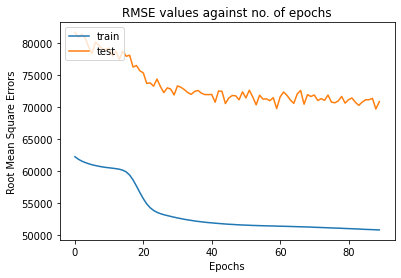

In [72]:
rmse_train = histories['1c'].history['root_mean_squared_error']
rmse_test = histories['1c'].history['val_root_mean_squared_error']
#skip first 10 epochs
plt.plot(rmse_train[10:]) 
plt.plot(rmse_test[10:]) 
plt.title('RMSE values against no. of epochs')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Errors')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./output_1b/1d_rmse.png')
plt.show()

e) State the epoch with the lowest test error. State the test R2 value at 
that epoch.

In [73]:
print("Epoch with lowest test error")
lowest_error = rmse_test.index(min(rmse_test))
print("Epoch: " + str(lowest_error + 1))

history = pd.DataFrame(histories['1c'].history)
r_sq_1e = history['val_r_square'][lowest_error]
print("R^2 value: " + str(r_sq_1e))

rmse_1e = history['val_root_mean_squared_error'][lowest_error]
print("RMSE value: " + str(rmse_1e))

Epoch with lowest test error
Epoch: 99
R^2 value: 0.8137280941009521
RMSE value: 69742.46875


f) Using the model from that best epoch, plot the predicted values and 
target values for a batch of 128 test samples.

In [74]:
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
model.load_weights(checkpoint_filepath)
test_batch = val_ds.take(1)
y_predicted = model.predict(test_batch)

for x,y in test_batch:
  y_target = y

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


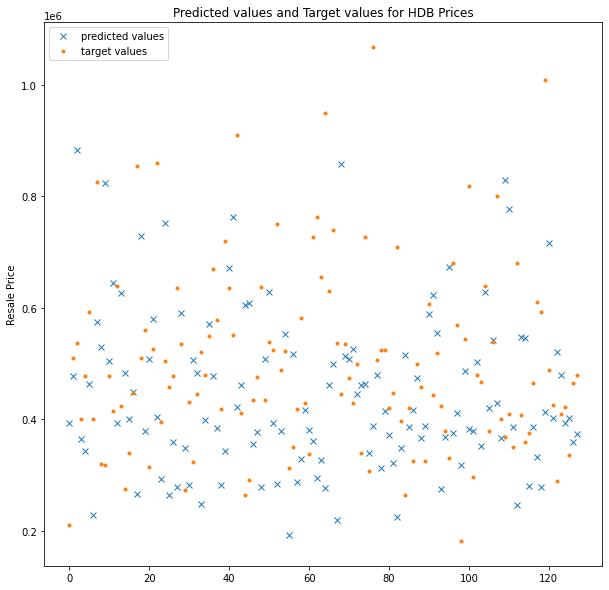

In [75]:
plt.figure(figsize=(10,10))
plt.plot(y_predicted, label = 'predicted values', marker = 'x', linestyle = 'None')
plt.plot(y_target, label = 'target values', marker = '.', linestyle = 'None')
plt.title('Predicted values and Target values for HDB Prices')
plt.ylabel('Resale Price')
plt.legend(loc = 'upper left')
plt.savefig('./output_1b/1f.png')
plt.show()

## Q2
Instead of using one-hot encoding, an alternative approach entails the use of embeddings 
to encode categorical variables. Such an approach utilises the ability of neural networks to 
learn richer representations of the data – an edge it has over traditional ML models.

a) Add an Embedding layer with output_dim = floor(num_categories/2) 
after the one-hot embeddings for categorical variables.

In [76]:
def encode_categorical_feature_2b(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class() 

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

b) The Embedding layer produces a 2D output (3D, including batch), 
which cannot be concatenated with the other features. Look through 
the Keras layers API to determine which layer to add in, such that all 
the features can be concatenated. Train the model using the same 
configuration as Q1.

In [77]:
def model_2b():
    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_encoded_2b = encode_categorical_feature_2b(month, "month", train_ds, False)
    #Number of categories 
    month_unique_values = len(unique(train_dataframe['month'])) + 1
    #Add embedding layer
    month_embedded = layers.Embedding(month_unique_values, output_dim = math.floor(month_unique_values/2))(month_encoded_2b)
    #Flatten layer 3D -> 2D 
    month_flattened = layers.Flatten()(month_embedded)


    # Categorical feature encoded as string
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
    storey_range_encoded_2b = encode_categorical_feature_2b(storey_range, "storey_range", train_ds, True)
    #Number of categories 
    storey_unique_values = len(unique(train_dataframe['storey_range'])) + 1
    #Add embedding layer
    storey_embedded = layers.Embedding(storey_unique_values, output_dim = math.floor(storey_unique_values/2))(storey_range_encoded_2b)
    #Flatten layer 3D -> 2D 
    storey_flattened = layers.Flatten()(storey_embedded)

    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    flat_model_type_encoded_2b = encode_categorical_feature_2b(flat_model_type, "flat_model_type", train_ds, True)
    #Number of categories 
    flat_model_unique_values = len(unique(train_dataframe['flat_model_type'])) + 1
    #Add embedding layer
    flat_model_embedded = layers.Embedding(flat_model_unique_values, output_dim = math.floor(flat_model_unique_values/2))(flat_model_type_encoded_2b)
    #Flatten layer 3D -> 2D 
    flat_model_flattened = layers.Flatten()(flat_model_embedded)

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    all_inputs_2b = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

    input_features_2b = layers.concatenate(
        [
            month_flattened,
            storey_flattened,
            flat_model_flattened,
            floor_area_sqm_encoded,
            remaining_lease_years_encoded,
            degree_centrality_encoded,
            eigenvector_centrality_encoded,
            dist_to_nearest_stn_encoded,
            dist_to_dhoby_encoded,
        ]
    )
    
    # feedforward network for embedded features
    x_2b = layers.Dense(10, activation="relu")(input_features_2b)
    output_2b = layers.Dense(1, activation="linear")(x_2b)
    model_2b = tf.keras.Model(all_inputs_2b, output_2b)

    model_2b.compile(optimizer = optimizer, loss = mse, metrics = [tf.keras.metrics.RootMeanSquaredError(), tf_addons.metrics.RSquare(y_shape=(1,))])
    histories ['2b'] = model_2b.fit(train_ds, batch_size = batch_size, 
                                 epochs = num_epochs, validation_data = val_ds, 
                                 callbacks = None)
    
model_2b()

Epoch 1/100


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 3s 3ms/step - loss: 17135542272.0000 - root_mean_squared_error: 130902.7969 - r_square: 0.2795 - val_loss: 9828288512.0000 - val_root_mean_squared_error: 99137.7266 - val_r_square: 0.6236
Epoch 2/100
683/683 [==============================] - 2s 3ms/step - loss: 6455258112.0000 - root_mean_squared_error: 80344.6172 - r_square: 0.7286 - val_loss: 8083354624.0000 - val_root_mean_squared_error: 89907.4766 - val_r_square: 0.6904
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 5563437056.0000 - root_mean_squared_error: 74588.4531 - r_square: 0.7661 - val_loss: 7495750656.0000 - val_root_mean_squared_error: 86578.0000 - val_r_square: 0.7129
Epoch 4/100
683/683 [==============================] - 2s 3ms/step - loss: 4989392896.0000 - root_mean_squared_error: 70635.6328 - r_square: 0.7902 - val_loss: 7545644032.0000 - val_root_mean_squared_error: 86865.6641 - val_r_square: 0.7110
Epoch 5/100
683/683 [=========================

Epoch 35/100
683/683 [==============================] - 2s 3ms/step - loss: 2719647488.0000 - root_mean_squared_error: 52150.2383 - r_square: 0.8857 - val_loss: 5559676416.0000 - val_root_mean_squared_error: 74563.2344 - val_r_square: 0.7871
Epoch 36/100
683/683 [==============================] - 2s 3ms/step - loss: 2718352896.0000 - root_mean_squared_error: 52137.8242 - r_square: 0.8857 - val_loss: 4901429248.0000 - val_root_mean_squared_error: 70010.2109 - val_r_square: 0.8123
Epoch 37/100
683/683 [==============================] - 2s 2ms/step - loss: 2718234368.0000 - root_mean_squared_error: 52136.6875 - r_square: 0.8857 - val_loss: 5356997632.0000 - val_root_mean_squared_error: 73191.5156 - val_r_square: 0.7948
Epoch 38/100
683/683 [==============================] - 2s 3ms/step - loss: 2712014592.0000 - root_mean_squared_error: 52077.0078 - r_square: 0.8860 - val_loss: 5418322432.0000 - val_root_mean_squared_error: 73609.2578 - val_r_square: 0.7925
Epoch 39/100
683/683 [==========

Epoch 69/100
683/683 [==============================] - 2s 2ms/step - loss: 2704146432.0000 - root_mean_squared_error: 52001.4062 - r_square: 0.8863 - val_loss: 5094478336.0000 - val_root_mean_squared_error: 71375.6172 - val_r_square: 0.8049
Epoch 70/100
683/683 [==============================] - 2s 2ms/step - loss: 2708744448.0000 - root_mean_squared_error: 52045.6016 - r_square: 0.8861 - val_loss: 4823249408.0000 - val_root_mean_squared_error: 69449.6172 - val_r_square: 0.8153
Epoch 71/100
683/683 [==============================] - 2s 2ms/step - loss: 2706606848.0000 - root_mean_squared_error: 52025.0586 - r_square: 0.8862 - val_loss: 4889348608.0000 - val_root_mean_squared_error: 69923.8750 - val_r_square: 0.8128
Epoch 72/100
683/683 [==============================] - 2s 3ms/step - loss: 2703898112.0000 - root_mean_squared_error: 51999.0195 - r_square: 0.8863 - val_loss: 4512169472.0000 - val_root_mean_squared_error: 67172.6875 - val_r_square: 0.8272
Epoch 73/100
683/683 [==========

c) Compare the current model performances in terms of both test RMSE 
and test R2 with the model from Q1 (at their own best epochs) and 
suggest a possible reason for the difference in performance. 

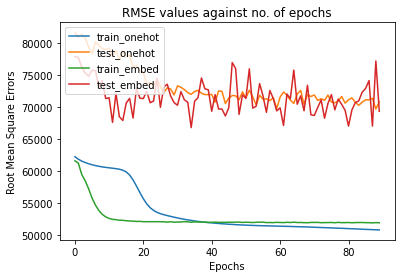

One-hot: Epoch with lowest test error
Epoch: 99
R^2 value: 0.8137280941009521
RMSE value: 69742.46875

Embed: Epoch with lowest test error
Epoch: 45
R^2 value: 0.8289065361022949
RMSE value: 72035.359375


In [78]:
rmse_train = histories['1c'].history['root_mean_squared_error']
rmse_test = histories['1c'].history['val_root_mean_squared_error']
rmse_train_2b = histories['2b'].history['root_mean_squared_error']
rmse_test_2b = histories['2b'].history['val_root_mean_squared_error']
#skip first 10 epochs
plt.plot(rmse_train[10:]) 
plt.plot(rmse_test[10:]) 
plt.plot(rmse_train_2b[10:]) 
plt.plot(rmse_test_2b[10:]) 
plt.title('RMSE values against no. of epochs')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square Errors')
plt.legend(['train_onehot', 'test_onehot', 'train_embed', 'test_embed'], loc = 'upper left')
plt.savefig('./output_1b/2c_rmse.png')
plt.show()

#One-hot: best epoch
print("One-hot: Epoch with lowest test error")
print("Epoch: " + str(lowest_error + 1))
print("R^2 value: " + str(r_sq_1e))
print("RMSE value: " + str(rmse_1e))
print()

#Embedded: best epoch
print("Embed: Epoch with lowest test error")
lowest_error_2b = rmse_test_2b.index(min(rmse_test_2b))
print("Epoch: " + str(lowest_error_2b + 1))
history_2b = pd.DataFrame(histories['2b'].history)
r_sq_2b = history_2b['val_r_square'][lowest_error_2b]
print("R^2 value: " + str(r_sq_2b))
rmse_2b = history['val_root_mean_squared_error'][lowest_error_2b]
print("RMSE value: " + str(rmse_2b))

The epoch with the lowest error is at 99 for one-hot encoding and at 45 for embedding. Embedding makes use of the underlying relationships between categorical features as they will group data together based on the occurrences of these data. One-hot simply indicates the presence of each possible value in the original data.

## Q3
Recursive feature elimination (RFE) is a feature selection method that removes 
unnecessary features from the inputs. It can also shed some insights on how much each 
feature contributes to the prediction task.

a) Continue with the model architecture you have after Q2. Via a callback, 
introduce early stopping (based on val_loss, with patience of 10 epochs) to 
the model.

In [80]:
def model_3():
    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_encoded_3 = encode_categorical_feature_2b(month, "month", train_ds, False)
    #Number of categories 
    month_unique_values = len(unique(train_dataframe['month'])) + 1
    #Add embedding layer
    month_embedded = layers.Embedding(month_unique_values, output_dim = math.floor(month_unique_values/2))(month_encoded_3)
    #Flatten layer 3D -> 2D 
    month_flattened = layers.Flatten()(month_embedded)


    # Categorical feature encoded as string
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
    storey_range_encoded_3 = encode_categorical_feature_2b(storey_range, "storey_range", train_ds, True)
    #Number of categories 
    storey_unique_values = len(unique(train_dataframe['storey_range'])) + 1
    #Add embedding layer
    storey_embedded = layers.Embedding(storey_unique_values, output_dim = math.floor(storey_unique_values/2))(storey_range_encoded_3)
    #Flatten layer 3D -> 2D 
    storey_flattened = layers.Flatten()(storey_embedded)

    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    flat_model_type_encoded_3 = encode_categorical_feature_2b(flat_model_type, "flat_model_type", train_ds, True)
    #Number of categories 
    flat_model_unique_values = len(unique(train_dataframe['flat_model_type'])) + 1
    #Add embedding layer
    flat_model_embedded = layers.Embedding(flat_model_unique_values, output_dim = math.floor(flat_model_unique_values/2))(flat_model_type_encoded_3)
    #Flatten layer 3D -> 2D 
    flat_model_flattened = layers.Flatten()(flat_model_embedded)

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    all_inputs_3 = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

    input_features_3 = layers.concatenate(
        [
            month_flattened,
            storey_flattened,
            flat_model_flattened,
            floor_area_sqm_encoded,
            remaining_lease_years_encoded,
            degree_centrality_encoded,
            eigenvector_centrality_encoded,
            dist_to_nearest_stn_encoded,
            dist_to_dhoby_encoded,
        ]
    )
    
    # feedforward network for embedded features
    x_3 = layers.Dense(10, activation="relu")(input_features_3)
    output_3 = layers.Dense(1, activation="linear")(x_3)
    model_3 = tf.keras.Model(all_inputs_3, output_3)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
    
    model_3.compile(optimizer = optimizer, loss = mse, metrics = [tf.keras.metrics.RootMeanSquaredError(), tf_addons.metrics.RSquare(y_shape=(1,))])
    histories ['3'] = model_3.fit(train_ds, batch_size = batch_size, 
                                 epochs = num_epochs, validation_data = val_ds, 
                                 callbacks = [early_stopping])
    
model_3()

Epoch 1/100
683/683 [==============================] - 3s 3ms/step - loss: 17598939136.0000 - root_mean_squared_error: 132661.0000 - r_square: 0.2600 - val_loss: 9971516416.0000 - val_root_mean_squared_error: 99857.4844 - val_r_square: 0.6181
Epoch 2/100
683/683 [==============================] - 2s 2ms/step - loss: 6622744064.0000 - root_mean_squared_error: 81380.2422 - r_square: 0.7215 - val_loss: 8382374400.0000 - val_root_mean_squared_error: 91555.3047 - val_r_square: 0.6790
Epoch 3/100
683/683 [==============================] - 2s 2ms/step - loss: 5739853824.0000 - root_mean_squared_error: 75761.8203 - r_square: 0.7587 - val_loss: 7944104448.0000 - val_root_mean_squared_error: 89129.7031 - val_r_square: 0.6958
Epoch 4/100
683/683 [==============================] - 2s 2ms/step - loss: 5130125312.0000 - root_mean_squared_error: 71624.8906 - r_square: 0.7843 - val_loss: 7060692480.0000 - val_root_mean_squared_error: 84027.9297 - val_r_square: 0.7296
Epoch 5/100
683/683 [=============

b) Start by removing one input feature whose removal leads to the minimum 
drop (or maximum improvement) in performance. Repeat the procedure 
recursively on the reduced input set until the optimal number of input 
features is reached. Remember to remove features one at a time. Record 
the RMSE of each experiment neatly in a table.

c) Compare the performances of the model with all 9 input features (from Q2) and the best model arrived at by RFE, in terms of both RMSE and R2.

In [107]:
#binary mask 
def binary_mask(i, features):
    feature_i = np.array([x for x in range(len(features))])
    mask = np.not_equal(feature_i, i)
    return mask 

def table_row_label(i, all_inputs, remove_feature):
    row_label = all_inputs[i]
    for feature in remove_feature:
        row_label += ", " + feature
    return row_label

#train model for 1
def train_model(features, input_list, early = True):
    concatenate_inputs = layers.concatenate(features)
    x_3 = layers.Dense(10, activation="relu")(concatenate_inputs)
    output_3 = layers.Dense(1, activation="linear")(x_3)
    model_3 = tf.keras.Model(all_inputs, output_3)

    model_3.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                    loss = keras.losses.MeanSquaredError(),
                    metrics = [keras.metrics.RootMeanSquaredError(), tf_addons.metrics.RSquare(y_shape=(1,))])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)
    histories['3b'] = model_3.fit(train_ds, batch_size = batch_size, verbose=0, epochs = num_epochs, validation_data=val_ds, callbacks=[early_stopping])

    #values for best epoch - lowest error
    best_epoch = histories['3b'].history['val_root_mean_squared_error'].index(min(histories['3b'].history['val_root_mean_squared_error']))
    best_epoch_r2 = histories['3b'].history['val_r_square'][best_epoch]
    best_epoch_rmse = histories['3b'].history['val_root_mean_squared_error'][best_epoch]
    best_epoch_loss = histories['3b'].history['val_loss'][best_epoch]

    return best_epoch, best_epoch_r2, best_epoch_rmse, best_epoch_loss, early_stopping

#remove one by one
def remove_feature(all_features, all_input, all_inputs_str, feature_to_remove = []):
    features = list(all_features)
    inputs = list(all_input)
    str_all_input = list(all_inputs_str)
  
    remove_feature = []
    for feature in feature_to_remove:
        remove_feature.append(str_all_input[feature])
        del str_all_input[feature]
        del features[feature]
        del inputs[feature]
 
    feature_set_data = {}
    for i in range(len(features)):
        mask = binary_mask(i, features)
        print("Binary Mask: " + str(mask))

        remove_label = table_row_label(i, str_all_input, remove_feature)

        conc_feat = []
        for t, feature_at in zip(mask, features):
            if t:
                conc_feat.append(feature_at)

        conc_input = []
        for t1, input_at in zip(mask, inputs):
            if t1:
                conc_input.append(input_at)

        best_epoch, best_epoch_r2, best_epoch_rmse, best_epoch_loss, early_stopping = train_model(conc_feat, conc_input)

        model_data = {}
        model_data['best_epoch'] = best_epoch
        model_data['val_rmse'] = best_epoch_rmse
        model_data['val_r2'] = best_epoch_r2
        model_data['val_loss'] = best_epoch_loss
        feature_set_data['remove ' + remove_label] = model_data

    return feature_set_data

In [108]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded_3 = encode_categorical_feature_2b(month, "month", train_ds, False)
#Number of categories 
month_unique_values = len(unique(train_dataframe['month'])) + 1
#Add embedding layer
month_embedded = layers.Embedding(month_unique_values, output_dim = math.floor(month_unique_values/2))(month_encoded_3)
#Flatten layer 3D -> 2D 
month_flattened = layers.Flatten()(month_embedded)

# Categorical feature encoded as string
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded_3 = encode_categorical_feature_2b(storey_range, "storey_range", train_ds, True)
#Number of categories 
storey_unique_values = len(unique(train_dataframe['storey_range'])) + 1
#Add embedding layer
storey_embedded = layers.Embedding(storey_unique_values, output_dim = math.floor(storey_unique_values/2))(storey_range_encoded_3)
#Flatten layer 3D -> 2D 
storey_flattened = layers.Flatten()(storey_embedded)

flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded_3 = encode_categorical_feature_2b(flat_model_type, "flat_model_type", train_ds, True)
#Number of categories 
flat_model_unique_values = len(unique(train_dataframe['flat_model_type'])) + 1
#Add embedding layer
flat_model_embedded = layers.Embedding(flat_model_unique_values, output_dim = math.floor(flat_model_unique_values/2))(flat_model_type_encoded_3)
#Flatten layer 3D -> 2D 
flat_model_flattened = layers.Flatten()(flat_model_embedded)

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_inputs = [
    month,
    storey_range,
    flat_model_type,
    floor_area_sqm,
    remaining_lease_years,
    degree_centrality,
    eigenvector_centrality,
    dist_to_nearest_stn,
    dist_to_dhoby,
]

all_features = [
    month_flattened,
    storey_flattened,
    flat_model_flattened,
    floor_area_sqm_encoded,
    remaining_lease_years_encoded,
    degree_centrality_encoded,
    eigenvector_centrality_encoded,
    dist_to_nearest_stn_encoded,
    dist_to_dhoby_encoded,
]

In [111]:
overall_lowest_rmse = float('inf')
removed = []
best_model = []

for i in range(len(all_inputs)): 
    all_inputs_list = []
    for j in range(len(all_inputs)):
        all_inputs_list.append(list(all_inputs)[j].name)

    feature_set_data = remove_feature(all_features, list(all_inputs), all_inputs_list)

    rmse_data = []
    r2_data = []
    for one_key in feature_set_data.keys():
        rmse_data.append(feature_set_data[one_key]['val_rmse'])
        r2_data.append(feature_set_data[one_key]['val_r2'])
        
    rmse_df = pd.DataFrame({'RMSE': rmse_data})
    r2_df = pd.DataFrame({'R^2': r2_data})
    print(rmse_df)
    print(r2_df)
    
    lowest_rmse = min(rmse_data)
    if lowest_rmse <= overall_lowest_rmse:
        best_model = []
        best_model.append(rmse_data)
        best_model.append(r2_data)
        print(best_model)
        overall_lowest_rmse = lowest_rmse
        lowest_rmse_i = rmse_data.index(lowest_rmse)
        removed.append(all_inputs[lowest_rmse_i].name)
        del all_inputs[lowest_rmse_i]
        del all_features[lowest_rmse_i]
    else:
        print("Feature Removed: ", removed)
        break

Binary Mask: [False  True  True  True  True  True  True  True  True]


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Binary Mask: [ True False  True  True  True  True  True  True  True]
Binary Mask: [ True  True False  True  True  True  True  True  True]
Binary Mask: [ True  True  True False  True  True  True  True  True]
Binary Mask: [ True  True  True  True False  True  True  True  True]
Binary Mask: [ True  True  True  True  True False  True  True  True]
Binary Mask: [ True  True  True  True  True  True False  True  True]
Binary Mask: [ True  True  True  True  True  True  True False  True]
Binary Mask: [ True  True  True  True  True  True  True  True False]
           RMSE
0  63423.148438
1  65931.062500
2  67576.210938
3  66038.460938
4  76362.718750
5  67227.468750
6  72211.218750
7  73459.960938
8  87244.164062
        R^2
0  0.845955
1  0.833532
2  0.825121
3  0.832990
4  0.776685
5  0.826921
6  0.800308
7  0.793341
8  0.708509
[[63423.1484375, 65931.0625, 67576.2109375, 66038.4609375, 76362.71875, 67227.46875, 72211.21875, 73459.9609375, 87244.1640625], [0.8459551334381104, 0.8335316181182861

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Binary Mask: [ True False  True  True  True  True  True  True]


KeyboardInterrupt: 

For the best model arrived at by RFE, the RMSE is significantly lower but the R^2 value is about the same.

d) By examining the changes in model performance whenever a feature is 
removed, evaluate the usefulness of each feature for the task of HDB resale 
price prediction.

A higher RSME value without a particular feature would mean that that particular feature is more important because when that feature is removed, the error rate becomes higher. A lower RSME value without a particular feature would mean the opposite, it would mean that that feature is less important.
Hence, in this case, the most important factor (with the highest RSME) would be dist_to_dhoby (last value - This can also be seen from printing the feature set data dictionary's keys).

In [112]:
print(feature_set_data.keys())

dict_keys(['remove month', 'remove storey_range', 'remove flat_model_type', 'remove floor_area_sqm', 'remove remaining_lease_years', 'remove degree_centrality', 'remove eigenvector_centrality', 'remove dist_to_nearest_stn', 'remove dist_to_dhoby'])


## Conclusion

We could observe the change in the RSME value. A bigger change in the RSME value without that particular feature would mean that that feature plays a bigger part in affecting the price.